# Checking the Installation


In [1]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i5-10400F CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


# Inicjalizacja liczb dualnych

In [2]:
# zdefiniowanie struktury liczby Dualnej - begin
struct Dual{T <:Number} <:Number
  v::T
  dv::T
end

In [3]:
# Część odpowiedzialna za przeciążenia 
import Base: +, -, *, /, ^
-(x::Dual) = Dual(-x.v, -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v, x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v, x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v, x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)
^(x::Dual, y::Dual) = Dual( x.v ^ y.v, x^y*log(x))
import Base: abs, sin, cos, tan, exp, sqrt, isless
abs(x::Dual) = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual) = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual) = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual) = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual) = Dual(exp(x.v), exp(x.v)*x.dv)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

In [4]:
# Funkcje pomocnicze
import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

In [5]:
# Promocja typów i konwersja
import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))

convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))

convert(::Type{Dual{T}}, x::Float64) where T = Dual(convert(T, x), zero(T))

promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}

promote_rule (generic function with 123 methods)

In [6]:
# Zdefiniowanie zarodka 
ϵ = Dual(0., 1.)

(0.0) + [1.0ϵ]

# Definiowanie funkcji

In [7]:
ReLU(x) = max(zero(x),x)
σ(x) = one(x) / (one(x) + exp(-x))
softmax(x) = exp.(x) ./ sum(exp.(x))
tanh(x) = 2.0 / (one(x) +exp(-2.0x)) - one(x)
f(x) = x > zero(x) ? x : zero(x)
sink(x) = sin(x*x)

sink (generic function with 1 method)

In [8]:
# x & y
x = -1.0:0.05:+1.0
y = partials.(f.(x.+ϵ));

# Różniczkowanie w przód

In [9]:
# funkcja odpowiedzialna za różniczkowanie
D = derivative(f, x) = partials(f(Dual(x, one(x))))

derivative (generic function with 1 method)

In [10]:
y = @.f(x+ϵ)

41-element Array{Dual{Float64},1}:
  (0.0) + [0.0ϵ]
  (0.0) + [0.0ϵ]
  (0.0) + [0.0ϵ]
  (0.0) + [0.0ϵ]
  (0.0) + [0.0ϵ]
  (0.0) + [0.0ϵ]
  (0.0) + [0.0ϵ]
  (0.0) + [0.0ϵ]
  (0.0) + [0.0ϵ]
  (0.0) + [0.0ϵ]
  (0.0) + [0.0ϵ]
  (0.0) + [0.0ϵ]
  (0.0) + [0.0ϵ]
               ⋮
 (0.45) + [1.0ϵ]
  (0.5) + [1.0ϵ]
 (0.55) + [1.0ϵ]
  (0.6) + [1.0ϵ]
 (0.65) + [1.0ϵ]
  (0.7) + [1.0ϵ]
 (0.75) + [1.0ϵ]
  (0.8) + [1.0ϵ]
 (0.85) + [1.0ϵ]
  (0.9) + [1.0ϵ]
 (0.95) + [1.0ϵ]
  (1.0) + [1.0ϵ]

In [11]:
using Plots

In [12]:
D(sink,3.14)

-5.695614741035545

In [13]:
# x & y
x = -1.0:0.05:+1.0
y = partials.(f.(x.+ϵ));
function forward_d(name)
    y = partials.(name.(x .+ϵ));
    center_diff(f, xo; dx=1e-3) = (f(xo+dx)- f(xo-dx))/2dx
    yf = center_diff.(name,x;dx=1e-1)

    plot(x, yf, line=nothing, marker=:circle, markersize=5., label = "Central difference")
    plot!(x, y, line=nothing, marker=:square, markersize=3., label = "Forward differentation")
    xaxis!("x")
    yaxis!("y")
end

forward_d (generic function with 1 method)

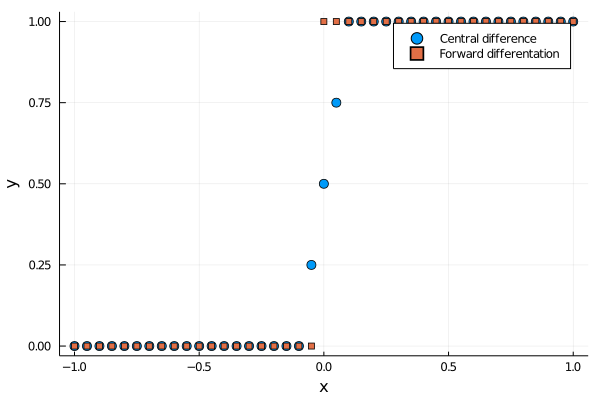

In [14]:
forward_d(ReLU)

# Inicjalizacja funkcji do różniczkowania w tył

In [15]:
abstract type Node end
abstract type Operator end
abstract type LeafNode <: Node end

In [16]:
mutable struct Variable{T} <: LeafNode
    value::T
    grad::T
    Variable(val::T) where T          = new{T}(val, zero(val))
    Variable(val::T, grad::T) where T = new{T}(val, grad)
end

In [17]:
struct Method{OT} <: Operator
    f::OT
end

struct Broadcasted{OT} <: Operator
    f::OT
end

In [18]:
struct ComputableNode{OT <: Operator, AT <: Tuple, KT <: NamedTuple} <: Node
    op::OT
    args::AT
    kwargs::KT
end
ComputableNode(op::Function, args, kwargs) = ComputableNode(Method(op), args, kwargs)
ComputableNode(op, args)                   = ComputableNode(op, args, NamedTuple())

ComputableNode

In [19]:
mutable struct CachedNode{NT <: Node, OUT} <: Node
    node::NT
    out::OUT
end

function CachedNode(op, args...; kwargs...)
    node = ComputableNode(op, args, kwargs.data)
    out  = forward(node)
    CachedNode(node, out)
end

CachedNode

In [20]:
arg(x::ComputableNode, i::Int) = x.args[i]
args(x::ComputableNode) = x.args
kwargs(x::ComputableNode) = x.kwargs
operator(x::ComputableNode) = x.f

arg(x::CachedNode, i::Int) = x.node.args[i]
args(x::CachedNode) = x.node.args
kwargs(x::CachedNode) = x.node.kwargs
operator(x::CachedNode) = x.node.f

operator (generic function with 2 methods)

In [21]:
import Base: show
show(io::IO, x::Method)         = print(io, "fn ",  x.f);
show(io::IO, x::Operator)       = print(io, "op ",  x.f);
show(io::IO, x::Variable)       = print(io, "var ", x.value);
show(io::IO, x::CachedNode)     = print(io, "{cached (", x.node, ") => ", x.out, "}");
show(io::IO, x::ComputableNode) = print(io, "[", x.op, "](", x.args, ")");

In [22]:
forward(x) = x
forward(leaf::LeafNode) = value(leaf)
forward(node::ComputableNode) = forward(node.op, map(forward, node.args)...; map(forward, node.kwargs)...)
forward(cached::CachedNode) = (cached.out = forward(cached.node))
forward(op::Broadcasted, args...) = Broadcast.broadcasted(op.f, args...)
forward(op::Operator, args...; kwargs...) = op.f(args...; kwargs...)
forward(x::NT) where {NT <: Node} = error("forward method is not implemented for node type: $NT")

forward (generic function with 7 methods)

In [23]:

value(x) = x
value(x::Variable) = x.value
value(x::CachedNode) = value(x.out)
value(x::T) where {T <: Node} = error("Expected value in this node $x of type $T
 check if you defined a non-cached node
 or overload value function for your node.")

value (generic function with 5 methods)

In [24]:

function backward(x::Variable, grad)
    if isdefined(x, :grad)
        x.grad+= grad
    else
        x.grad = grad
    end
    nothing
end

function backward(node::CachedNode, f, grad)
    grad_inputs = gradient(node, grad)
    for (each, each_grad) in zip(args(node), grad_inputs)
        backward(each, each_grad)
    end
    nothing
end

function backward(cached::CachedNode, op::Broadcasted, grad)
    grad_inputs = gradient(cached, grad)
    for (each, each_grad) in zip(args(cached), grad_inputs)
        backward(each, each_grad)
    end
    nothing
end

backward(cached::CachedNode) = backward(cached, 1.0)
backward(cached::CachedNode, grad) = backward(cached, cached.node.op, grad)
backward(cached::CachedNode, op::Method, grad) = backward(cached, op.f, grad)
backward(cached::CachedNode, ::typeof(Broadcast.materialize), grad) = backward(arg(cached, 1), grad)

backward (generic function with 7 methods)

In [25]:
gradient(x::CachedNode, grad) = gradient(x.node.op, grad, x.out, map(value, x.node.args)...; map(value, x.node.kwargs)...)
gradient(x::Operator,   grad, out, args...; kwargs...) = gradient(x.f, grad, out, args...; kwargs...)
gradient(op, grad, out, args...; kwargs...) = error("gradient of operator $op is not defined\n
 Possible Fix:\n
 define one of the following:\n
 1. gradient(::typeof($op), grad, out, args...; kwargs...)\n
 2. gradient(op::Method{typeof($op)}, grad, out, args...; kwargs...)\n
 3. gradient(op::Broadcasted{typeof($op)}, grad, out, args...; kwargs...)\n")

gradient (generic function with 3 methods)

In [26]:
import Base: +, -, *, /
+(x::Node) = CachedNode(+, x)
-(x::Node) = CachedNode(-, x)
gradient(::typeof(+), grad, output, x) = (grad * 1, )
gradient(::typeof(-), grad, output, x) = (grad *-1, )
+(x::Node, y::Node) = CachedNode(+, x, y)
-(x::Node, y::Node) = CachedNode(-, x, y)
*(x::Node, y::Node) = CachedNode(*, x, y)
/(x::Node, y::Node) = CachedNode(/, x, y)
gradient(::typeof(+), grad, output, x, y) = (grad * one(x),   grad * one(y))
gradient(::typeof(-), grad, output, x, y) = (grad * one(x),   grad *-one(y))
gradient(::typeof(*), grad, output, x, y) = (grad * y,        grad * x)
gradient(::typeof(/), grad, output, x, y) = (grad * one(x)/y, grad *-x/y/y)

gradient (generic function with 9 methods)

In [27]:
import Base: abs, sin, cos, tan, exp, sqrt, isless
abs(x::Node)  = CachedNode(abs, x)
sin(x::Node)  = CachedNode(sin, x)
cos(x::Node)  = CachedNode(cos, x)
tan(x::Node)  = CachedNode(tan, x)
exp(x::Node)  = CachedNode(exp, x)
sqrt(x::Node) = CachedNode(sqrt, x)
isless(x::Node, y::Node) = isless(value(x), value(y))
gradient(::typeof(abs), grad, output, x)  = (grad * sign(x), )
gradient(::typeof(sin), grad, output, x)  = (grad * cos(x), )
gradient(::typeof(cos), grad, output, x)  = (grad *-sin(x), )
gradient(::typeof(tan), grad, output, x)  = (grad *(tan(x)^2 + 1), )
gradient(::typeof(exp), grad, output, x)  = (grad * exp(x), )
gradient(::typeof(sqrt), grad, output, x) = (grad * 0.5/sqrt(x), )
gradient(::typeof(tanh), grad, output, x)  = (grad * (1/cosh(x)^2), )
gradient(::typeof(cosh), grad, output, x)  = (grad * (sinh(x)), )


gradient (generic function with 17 methods)

In [28]:
import Base: convert, promote_rule
convert(::Type{Variable{T}}, x::Number) where T   = Variable(convert(T, x))
convert(::Type{Variable{T}}, x::Variable) where T = Variable(convert(T, x.value), convert(T, x.grad))
promote_rule(::Type{Variable{T}}, ::Type{R}) where {T,R} = Variable{promote_type(R,T)}

promote_rule (generic function with 149 methods)

In [29]:
struct ComputGraphStyle <: Broadcast.BroadcastStyle end
Base.BroadcastStyle(::Type{<:Node}) = ComputGraphStyle()
Broadcast.BroadcastStyle(s::ComputGraphStyle, x::Broadcast.BroadcastStyle) = s
Broadcast.broadcasted(::ComputGraphStyle, f, args...) = CachedNode(Broadcasted(f), args...)
Broadcast.broadcastable(x::Node) = x
Broadcast.materialize(x::Node) = CachedNode(Broadcast.materialize, x)
Base.similar(x::Node)                                      = Variable(similar(value(x)))
Base.similar(x::Node, dims::Dims)                          = Variable(similar(value(x), dims))
Base.similar(x::Node, eltype::Type{S}, dims::Dims) where S = Variable(similar(value(x), eltype, dims))

In [30]:
gradient(::Broadcasted{typeof(+)}, grad, output, x)    = @. (grad * 1, )
gradient(::Broadcasted{typeof(-)}, grad, output, x)    = @. (grad *-1, )
gradient(::Broadcasted{typeof(+)}, grad, output, x, y) = @. (grad * one(x),   grad * one(y))
gradient(::Broadcasted{typeof(-)}, grad, output, x, y) = @. (grad * one(x),   grad *-one(y))
gradient(::Broadcasted{typeof(*)}, grad, output, x, y) = @. (grad * y,        grad * x)
gradient(::Broadcasted{typeof(/)}, grad, output, x, y) = @. (grad * one(x)/y, grad *-x/y/y)
gradient(::Broadcasted{typeof(abs)}, grad, output, x)  = @. (grad * sign(x), )
gradient(::Broadcasted{typeof(sin)}, grad, output, x)  = @. (grad *  cos(x),  )
gradient(::Broadcasted{typeof(cos)}, grad, output, x)  = @. (grad * -sin(x), )
gradient(::Broadcasted{typeof(tan)}, grad, output, x)  = @. (grad * (tan(x)^2 + 1), )
gradient(::Broadcasted{typeof(exp)}, grad, output, x)  = @. (grad *  exp(x), )
gradient(::Broadcasted{typeof(sqrt)}, grad, output, x) = @. (grad *.5/sqrt(x), )
gradient(::Broadcasted{typeof(tanh)}, grad, output, x)  = @. (grad * (1/cosh(x)^2), )
gradient(::Broadcasted{typeof(cosh)}, grad, output, x)  = @. (grad * (sinh(x)), )

gradient (generic function with 31 methods)

In [31]:
x = Variable(1.0)
z = sin(x*x)
backward(z)
@show x.grad;

x.grad = 1.0806046117362795


In [32]:
x = Variable(3.14)
z = sin(x*x)
backward(z)
@show x.grad;

x.grad = -5.695614741035545


In [33]:

x = Variable(collect(-π:0.01:+π))
z = sin.(x.*x)
backward(z)

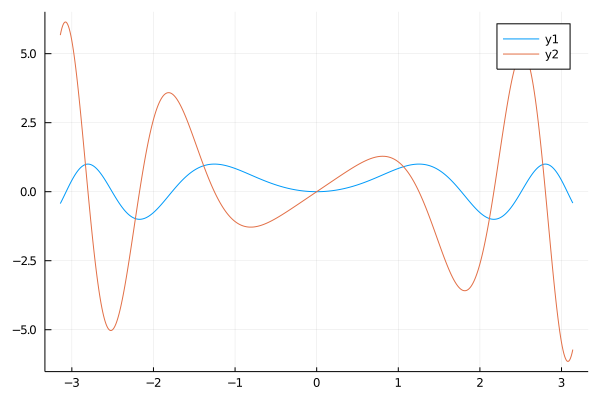

In [34]:
plot(value(x), value(z))
plot!(value(x), x.grad)

# Porównywanie 

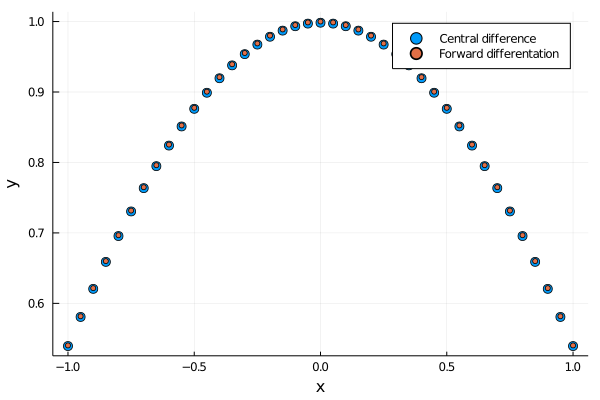

In [35]:
# x & y
x = -1.0:0.05:+1.0
y = partials.(f.(x.+ϵ));
function forward_d(name)
    y = partials.(name.(x .+ϵ));
    center_diff(f, xo; dx=1e-3) = (f(xo+dx)- f(xo-dx))/2dx
    yf = center_diff.(name,x;dx=1e-1)

    plot(x, yf, line=nothing, marker=:circle, markersize=5., label = "Central difference")
    plot!(x, y, line=nothing, marker=:circle, markersize=3., label = "Forward differentation")
    
    xaxis!("x")
    yaxis!("y")
end
forward_d(sin)

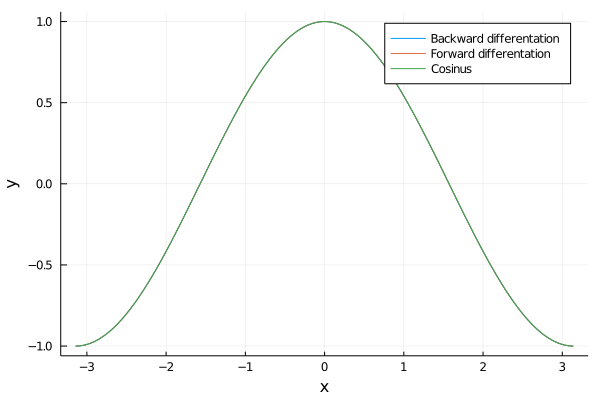

In [48]:
# zakres 
x = -π:0.01:+π
#x = 0.001:0.001:+1
# backward
w = Variable(collect(x))
q = sin.(w)  # tutaj podmiana
#q = sin.(exp.(w))
backward(q)

#forward

#y = partials.(f.(x.+ϵ));
#y = D(sink,x)
# y = partials.(sink.(x.+ϵ));
expk(k)=exp(k*k)
sinexp(a) = sin(exp(a))
y = partials.(sin.(x.+ϵ)); # TUTAJ PODMIANA

c = value.(cos.(x))

zmienna = w.grad

plot(value(w), zmienna,  markersize=1., label = "Backward differentation")
plot!(x, y,  markersize=1., label = "Forward differentation")
plot!(x, c,  markersize=0.1, label = "Cosinus")
xaxis!("x")
yaxis!("y")

In [49]:
roznica_cos = zmienna - c
roznica_cos_f = y - c
roznica = zmienna - y

629-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

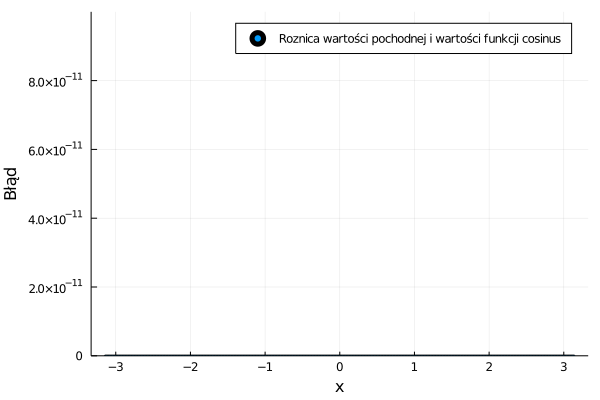

In [54]:
plot(x, roznica, line=nothing, marker=:circle, markersize=1., ylims = (0, 1e-010), label = "Roznica wartości pochodnej i wartości funkcji cosinus")
xaxis!("x")
yaxis!("Błąd")

In [ ]:
# jak zmierzyć czas 
# jak zmierzyć pamięć
# porównanie z wartościami dokładnymi

In [40]:
using BenchmarkTools

In [55]:
# backward
@benchmark backward(q) setup=(q = tanh.(w))

BenchmarkTools.Trial: 
  memory estimate:  10.13 KiB
  allocs estimate:  2
  --------------
  minimum time:     8.533 μs (0.00% GC)
  median time:      8.867 μs (0.00% GC)
  mean time:        9.602 μs (4.70% GC)
  maximum time:     637.067 μs (98.34% GC)
  --------------
  samples:          10000
  evals/sample:     3

In [56]:
# forward
@benchmark partials.(tanh.(x.+ϵ)) setup=(x=-5:0.01:+5)

BenchmarkTools.Trial: 
  memory estimate:  8.63 KiB
  allocs estimate:  10
  --------------
  minimum time:     25.599 μs (0.00% GC)
  median time:      26.500 μs (0.00% GC)
  mean time:        27.042 μs (0.00% GC)
  maximum time:     88.301 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [45]:
zmienna
using DelimitedFiles
writedlm( "tanh.csv",  zmienna, ',')

In [47]:
softmax(1)

1.0